## Lucas Oliveira Machado de Sousa

In [92]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

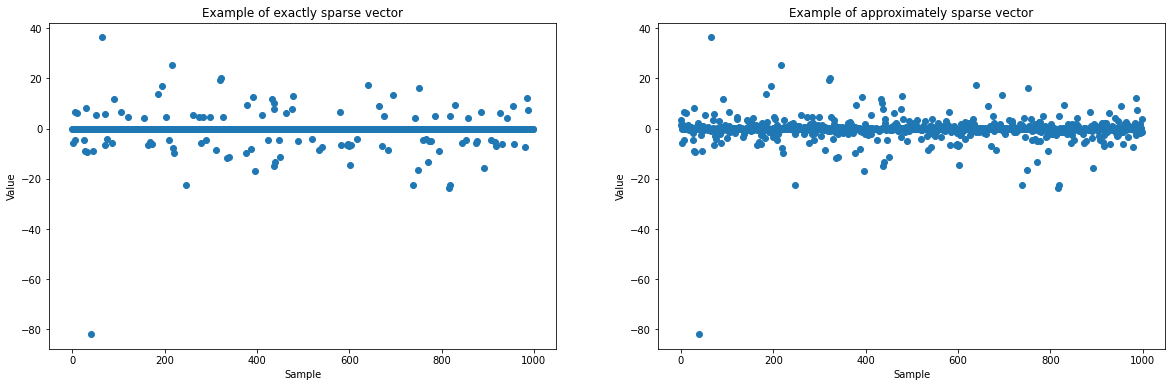

In [93]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**1)** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

A signal is said to be k-sparse if only k << t of its elements are non-zero. 

As for approximate sparsity, it's when only a small number k of signal samples have a large amplitude (i.e., there are many values close to zero, but not necessarily zero).

**2)** Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

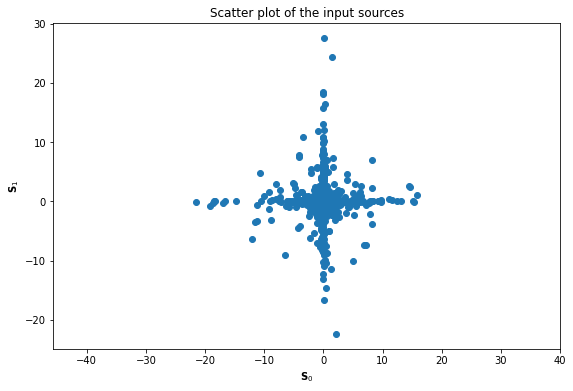

In [94]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation

# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = np.random.randn(n,t)**power # TO CHANGE

# TO DO : interpret the shape of the scatter plot you obtain
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

The scatter plot is star-shaped because the signal is sparse.

In [95]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

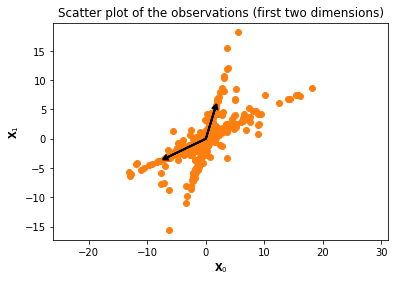

In [96]:
# TO DO : plot the scatter plot of X. What do you see ? 
# What do the directions of the lines you observe correspond ?
# Try several A matrices, noise_values and powers. Note your comments.

plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

In hyperspectral imaging, these arrows correspond to the direction of the multiplication of $s_{ik}$, the concentration of the $k^{th}$ material in the $i^{th}$ pixel, by $a_k$, the spectre of the $k^{th}$ material.

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

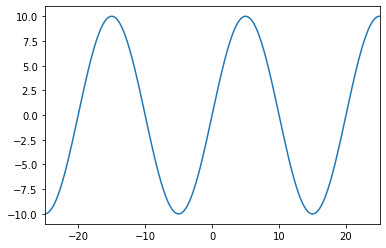

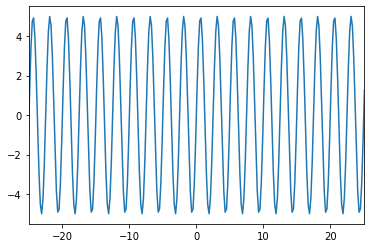

In [97]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

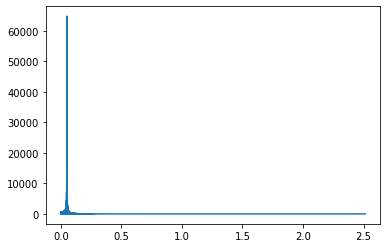

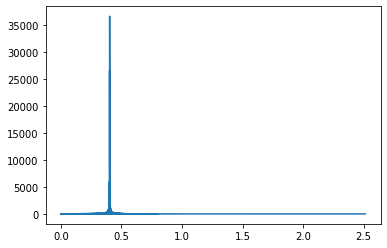

In [98]:
# Transformation into the DCT domain
Sf = sff.dct(S)
# TO DO : what is the objective of using the DCT?
# TO DO : plot the above DCT and justify what you see? Pay attention to the labeling of the x-axis. Try with sinus of various frequencies.

plt.figure()
plt.plot(np.linspace(0,2*np.pi*0.4, t), np.abs(Sf[0, :]))

plt.figure()
plt.plot(np.linspace(0,2*np.pi*0.4, t), np.abs(Sf[1, :]))
plt.show()


The objective of using the DCT is that we transform the original signal into a sparse one, a Dirac impulse at the frequency of the sinusoidal functions.

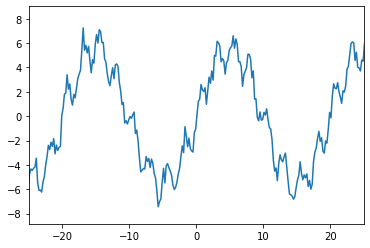

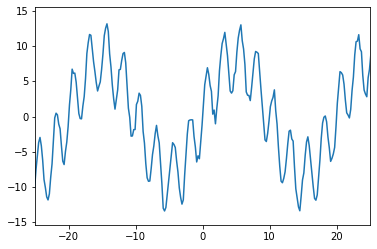

In [99]:
# Data generation : now, we will create a mixture X = AS + N
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A value, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# TO DO : plot the mixtures. Explain what you see.
# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

plt.figure()
plt.plot(x_abs, X[0])
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, X[1])
plt.xlim([-25,25])

plt.show()

When performing the multiplication of the matrices $AS$, we're basically changing the amplitudes of the two sine waves in S and summing then, therefore the result is a sine wave on the top of another. 

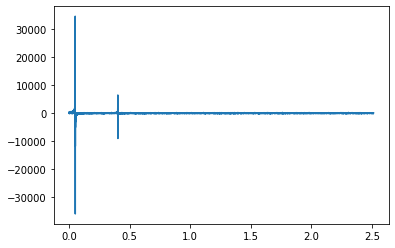

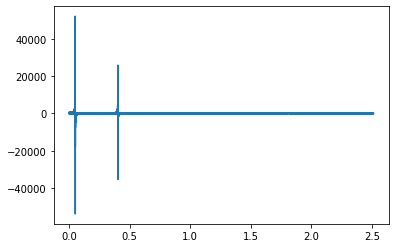

In [100]:
Xf = sff.dct(X)

plt.figure()
plt.plot(np.linspace(0,2*np.pi*0.4, t), Xf[0, :])

plt.figure()
plt.plot(np.linspace(0,2*np.pi*0.4, t), Xf[1, :])
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**2-1)** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


$$arg min_{A\in\mathbb{R}^{m\times n}, S \in \mathbb{R}^{n\times t}} \frac{1}{2} ||X-AS||^2_F + \lambda ||S||_1$$

The first term is the Data Attachment, which is smooth. The second term, Sparsity, is not smooth due to the $||.||_1$ norm. Therefore, the problem isn't smooth, but at least it's convex with A fixed.

**2-2)** Compute the gradient along the S variable of the data-fidelity term.



$$\nabla\left( \frac{1}{2} ||X-AS||^2_F\right) = -A^T(X-AS)$$

**2-3)**

Recall what the proximal operator of the l1-norm is.

It's the soft-thresholding operator.

$$(prox_{\lambda ||.||_1}(v))_i = S_{\lambda}(v) =
\begin{cases} 
      v_i-\lambda &, v_i \ge \lambda \\
      0 &, |v_i|\  \le \lambda \\
      v_i+\lambda &, v_i \le -\lambda.
\end{cases}$$

In [101]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)
  return S_est

**2-4)** In your report, explain the main idea of the ISTA algorithm. Then, implement it.

The proximal operator is a firmly non-expensive operator, and this method is based on the fixed point property:

If $s^*$ is a minimizer of $G(.)$, then $prox_{G(.)}(s^*) = s^*$.

It's just like a gradient descent, but since the function we want to maximize is not smooth we use the proximal operator.

In [102]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
  S_est = np.zeros((n, X.shape[1]))
  gamma = 0.9/np.linalg.norm(A.T @ A)
  for i in range(nbIt):
    S_est = prox_l1(S_est - gamma*(A.T @ (A@S_est-X)), lamb)
  return S_est

**2-5)** It's now time to play with the code : launch the ISTA algorithm and look at the results.

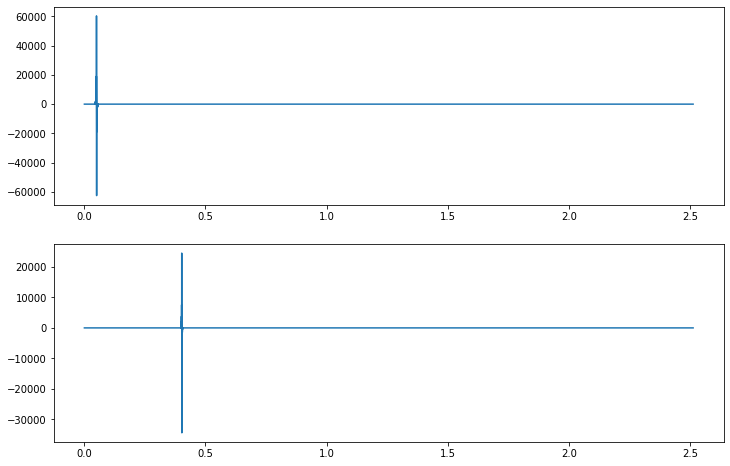

In [103]:
S_estf = ISTA(Xf, A, n=2,lamb=1000,nbIt = 1000)
# TO DO : try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?
# Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,2*np.pi*0.4,t),(S_estf[0]))
plt.subplot(2,1,2)
plt.plot(np.linspace(0,2*np.pi*0.4,t),(S_estf[1]))
plt.show()


We shouldn't use lambda values lower than zero. If we do so, not only we don't get a good regularization, but also we won't get sparse values. For values of lambda too large, the regularization is much stronger than the data fidelity, therefore the signal doesn't resemble the original signal. 

The sources exhibit exact sparsity, since due to the presence of a region with a value of exactly 0 in the proximal operator.

**2-6)** Transform the sources back in the direct domain. What do you see? Conclude.

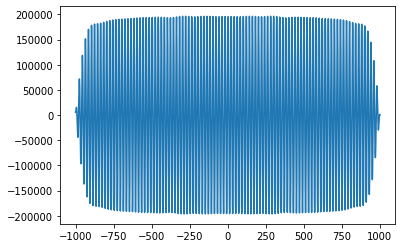

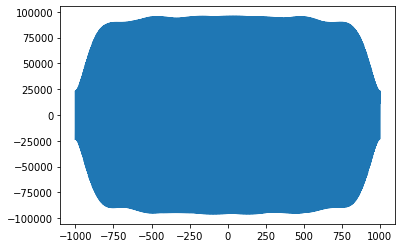

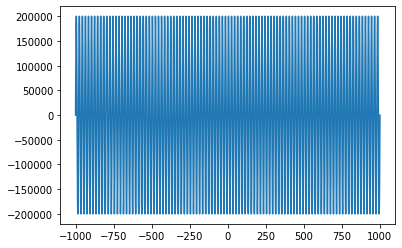

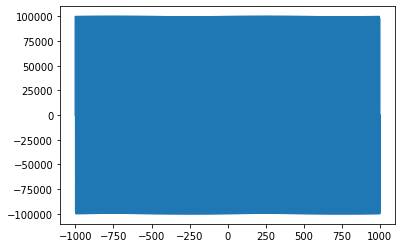

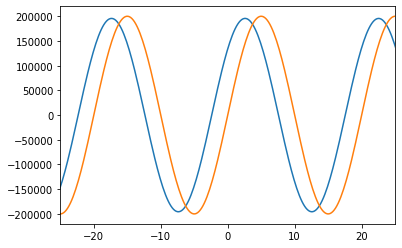

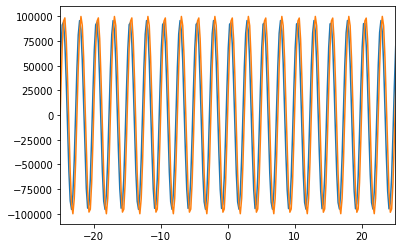

In [105]:
# TO DO : transform the estimated sources in the direct domain? Plot them. Explain the differences with the original sources you observe.
S_est = sff.dct(S_estf)

plt.figure()
plt.plot(x_abs, S_est[0])

plt.figure()
plt.plot(x_abs, S_est[1])


plt.figure()
plt.plot(x_abs, S[0]*20000)

plt.figure()
plt.plot(x_abs, S[1]*20000)

plt.figure()
plt.plot(x_abs, S_est[0])
plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, S_est[1])
plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])


plt.show()

# TO DO : compare the central parts of the original and estimated sources.

We see that we were able to succesfully recover the signals S, but with a small difference in phase.

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

1) Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

$$arg min_{A\in\mathbb{R}^{m\times n}, S \in \mathbb{R}^{n\times t}} \frac{1}{2} ||X-AS||^2_F + \lambda ||S||_1 +\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le 1\}}(A) $$

The first term is the Data Attachment, which is smooth. The second term, Sparsity, is not smooth due to the $||.||_1$ norm. The third term is the oblique constraint, which requires each column of A to have a unit energy so that we do not obtain degenerate solutions. Therefore, the problem is neither smooth nor convex, and so it's a difficult optimization problem.



2) Recall what the gradient of the data fidelity term over A is.

It's the same as in the precedent question on this gradient, since the data fidelity term is unchanged.

3) Compte the proximal operator of the oblique constraint. Implement it.

In [111]:
def prox_oblique(A):
  for j in range(A.shape[1]):
    A[:, j] = A[:, j]/np.maximum(np.linalg.norm(A[:, j]), 1)  
  return A

4) Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [112]:
def PALM(X, n=2, lamb=0, nbIt = 100):
    S_est = np.zeros((n,X.shape[1]))
    A_est = np.eye(X.shape[0],n)
    for i in range(nbIt):
      S_est = prox_l1(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)))*(A_est.T @ (X - A_est@S_est)), lamb)
      A_est = prox_oblique(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)))*(X - A_est @ S_est) @ S_est.T)
    
    return A_est,S_est

5) Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

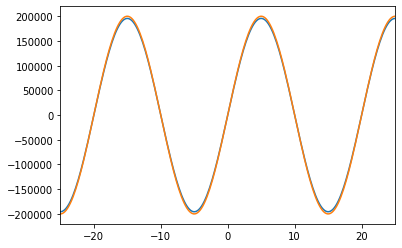

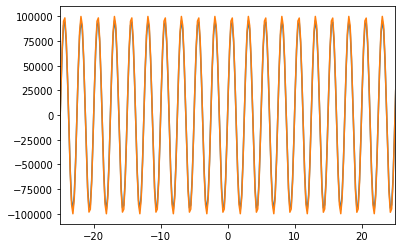

In [114]:
A_estf, S_estf = PALM(Xf, n=2, lamb=1000, nbIt=1000)
S_estf = sff.idct(S_estf)

plt.figure()
plt.plot(x_abs, S_estf[0])
plt.plot(x_abs,0.2e6*np.sin(2*np.pi*0.05*x_abs))
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, S_estf[1])
plt.plot(x_abs,0.1e6*np.sin(2*np.pi*0.4*x_abs))
plt.xlim([-25,25])

plt.show()

The result is excellent. The two estimated sources are very similar to the original ones.